# Skin Cancer Detection

Deep Learning aplicada ao diagnóstico de câncer de pele e de outras lesões na pele.

Para a criação do modelo se dará em duas partes:
- Rede Neural Convolucional (CNN) para classificação das doenças através da análise de imagens;
- Rede Neural Artificial do tipo Multilayer Perceptron (MLP) para realização do diagnóstico final, baseado nas saídas das CNNs e nos demais atributos preditores.
    
Para realização do treinamento, será utilizado o [Skin Cancer Mnist](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/home), fornecido pela plataforma [Kaggle](https://www.kaggle.com).

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from math import ceil
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt

## Redes Neurais Convolucionais

In [2]:
txtList = [r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_akiec.txt',
           r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_bcc.txt',
           r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_bkl.txt',
           r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_mel.txt',
           r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_nv.txt',
           r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\ensemble\predictions\pred_vasc.txt',]

folderList = [r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\akiec',
              r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\bcc',
              r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\bkl',
              r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\mel',
              r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\nv',
              r'C:\Users\7\Desktop\Desktop\dataset\cancer mnist\unbalanced\test\vasc']

In [3]:
df = pd.DataFrame()

In [4]:
# Importing the libraries
for txt in txtList:
    with open(txt, "rb") as fp:   # Unpickling
        predictions = pickle.load(fp)
    df = pd.concat([df, pd.Series((v[0] for v in predictions))], axis = 1)


In [5]:
import os
img_id = []
def load_images_from_folder(folder):
    images = []
    j = 0
    for filename in os.listdir(folder):
        images.append(filename[:12])
    return images
for folder in folderList:
    img_id = img_id + load_images_from_folder(folder)

In [6]:
df = pd.concat([pd.Series(img_id), df], axis = 1)

In [7]:
df.columns = ['image_id', 'akiec', 'bcc', 'bkl', 'mel', 'nv', 'vasc']

## Dataset 

In [8]:
dataset = pd.read_csv('HAM10000_metadata.csv')

#Categorização do atributo 'localization'
data_localization = pd.get_dummies(dataset.localization)
dataset = pd.concat([dataset, data_localization], axis=1)

#Categorização do atributo 'sex'
data_sex = pd.get_dummies(dataset.sex)
dataset = pd.concat([dataset, data_sex], axis=1)

dataset = dataset.drop(['sex', 'localization'], axis = 1)

dataset.columns =['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'abdomen', 'acral',
       'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand',
       'lower extremity', 'neck', 'scalp', 'trunk', 'unknown_loc',
       'upper extremity', 'female', 'male', 'unknown_sex']

dataset.head()

,lesion_id,image_id,dx,dx_type,age,abdomen,acral,back,chest,ear,...,hand,lower extremity,neck,scalp,trunk,unknown_loc,upper extremity,female,male,unknown_sex
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
newDataset = pd.merge(df, dataset, on='image_id')

In [10]:
newDataset.columns

Index(['image_id', 'akiec', 'bcc', 'bkl', 'mel', 'nv', 'vasc', 'lesion_id',
       'dx', 'dx_type', 'age', 'abdomen', 'acral', 'back', 'chest', 'ear',
       'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp',
       'trunk', 'unknown_loc', 'upper extremity', 'female', 'male',
       'unknown_sex'],
      dtype='object')

In [11]:
dataset = newDataset.drop(['image_id', 'lesion_id', 'dx_type'], axis = 1)

In [12]:
dataset.head()

,akiec,bcc,bkl,mel,nv,vasc,dx,age,abdomen,acral,...,hand,lower extremity,neck,scalp,trunk,unknown_loc,upper extremity,female,male,unknown_sex
0,0.978720,0.883363,0.238230,0.055368,0.005225,0.001041,akiec,75.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.772862,0.399394,0.021668,0.997450,0.000125,0.000392,akiec,70.0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0.029374,0.093358,0.201534,0.995622,0.549689,0.000908,akiec,75.0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.924068,0.562018,0.672589,0.993960,0.003192,0.000282,akiec,50.0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0.051971,0.020617,0.934258,0.998287,0.017259,0.000525,akiec,50.0,0,0,...,0,0,0,0,0,0,1,0,1,0


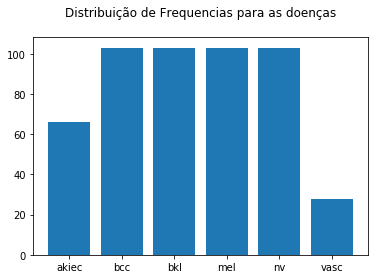

In [13]:
classes = []
freq = []
for i in range(len(dataset.groupby('dx').size())):
    classes.append(dataset.groupby('dx').size().index[i])
    freq.append(dataset.groupby('dx').size()[i])
    
plt.bar(classes, freq)
plt.title('Distribuição de Frequencias para as doenças\n')
plt.show()

## Regra da Pirâmide Geométrica

Implementação da Regra da Pirâmide Geométrica para determinação da quantidade de Neurônios Ocultos

        Nh = α·√(Ni·No) ; Nh = Número de Neurônios Ocultos
                          Ni = Número de Neurônios de Entrada
                          No = Número de Neurônios de Saída
                          α  = Constante

In [16]:
def piramide_geometrica(ni, no, alfa):
    nh = alfa*((ni*no)**(1/2))
    return ceil(nh)

##  Distribuição dos Neurônios em duas Camadas Ocultas

Função para gerar todas as possíveis 2-tuplas que representam o número de neurônios distribuídos por duas camadas ocultas de uma RNA do tipo MLP, dado o número de neurônios ocultos obtidos previamente pela Regra da Pirâmide Geométrica.

In [17]:
def hidden_layers(layers, nh):
    for i in range(1, nh):
        neurons_layers = (i, nh-i)
        layers.append(neurons_layers)
    return layers

### Criação de Lista de Camadas Ocultas a Partir da Regra da Pirâmide Geométrica

In [18]:
num_in = 26
num_out = 6
alpha = [0.5, 3]
layers = []

In [19]:
for i in range(len(alpha)):
    nh = piramide_geometrica(num_in, num_out, alpha[i])
    print('Para α = %.1f, Nh = %d'%(alpha[i],nh))
    hidden_layers(layers, nh)#insere cada possibilidade de camadas ocultas, dado o numero de neurônios, na lista 'layers'
    
print()
print('Distribuições de Camadas Ocultas:\n')
for i in layers:
    print(i)

Para α = 0.5, Nh = 7
Para α = 3.0, Nh = 38

Distribuições de Camadas Ocultas:

(1, 6)
(2, 5)
(3, 4)
(4, 3)
(5, 2)
(6, 1)
(1, 37)
(2, 36)
(3, 35)
(4, 34)
(5, 33)
(6, 32)
(7, 31)
(8, 30)
(9, 29)
(10, 28)
(11, 27)
(12, 26)
(13, 25)
(14, 24)
(15, 23)
(16, 22)
(17, 21)
(18, 20)
(19, 19)
(20, 18)
(21, 17)
(22, 16)
(23, 15)
(24, 14)
(25, 13)
(26, 12)
(27, 11)
(28, 10)
(29, 9)
(30, 8)
(31, 7)
(32, 6)
(33, 5)
(34, 4)
(35, 3)
(36, 2)
(37, 1)


## Busca em Grade

In [20]:
parameters = {'solver': ['lbfgs', 'adam', 'sgd'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': layers,
              'max_iter':[1000, 2000],
              'learning_rate_init':[0.0005, 0.0001],
              'learning_rate': ['adaptive', 'constant']}

gs = GridSearchCV(MLPClassifier(), 
                  parameters, 
                  cv=3, 
                  scoring='accuracy', verbose = 2)

In [15]:
x = dataset.drop(['dx'], axis = 1) #Atributos preditores
y = dataset.dx #Atributo Alvo

### Treinamento 

Treinamento de todas as combinações de RNAs definidas no GridSearchCV( )

In [22]:
gs.fit(x, y)

Fitting 3 folds for each of 4128 candidates, totalling 12384 fits
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] activati

[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=iden

[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=id

[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=id

[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.5s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=id

[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.6s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identi

[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.7s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identi

[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.3s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activati

[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.

[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[

[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] 

[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[

[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.

[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[

[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s

[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[

[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s

[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[

[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s

[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.

[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s

[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.2s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[

[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[

[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.

[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[

[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[

[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.0s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[

[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.

[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[

[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.9s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.2s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.3s
[

[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.

[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.6s

[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activat

[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.3s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.0s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation

[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activati

[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=iden

[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.1s
[CV] a

[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activati

[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV]

[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] act

[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=identity, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.3s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logist

[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.7s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logist

[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.5s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logist

[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.3s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.7s
[CV] activation=lo

[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.0s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=lo

[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=log

[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.7s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=lo

[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.5s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.6s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.0s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.1s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation

[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.1s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activat

[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.1s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activat

[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.

[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[

[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.

[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.4s

[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.7s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[

[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.

[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.7s
[

[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.

[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s

[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.8s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[

[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.

[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[

[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.

[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   4.4s
[CV] activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.9s

[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[

[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.3s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.

[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[

[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   1.0s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.6s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.

[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.3s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.3s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.2s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.1s

[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   4.2s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   4.3s
[CV] activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   1.0s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[

[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.6s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.

[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.1s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   2.0s
[

[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.7s
[CV] 

[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.3s
[CV] activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.

[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   3.0s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   3.1s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.6s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.9s

[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   4.0s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   1.4s
[CV] activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.9s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.5s
[

[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.2s
[CV] activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.

[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.4s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.1s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.3s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.4s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activat

[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.6s
[CV]

[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.6s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.7s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activa

[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.7s
[CV] activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.7s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.7s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.3s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.4s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.9s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   1.1s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.5s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.7s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.0s
[CV] activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.4s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   2.2s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.4s
[CV] activati

[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] act

[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.7s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.6s
[CV] a

[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activati

[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(1, 6

[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(2

[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(2

[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(3, 4)

[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.9s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), l

[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.9s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(4, 3),

[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(5, 2

[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(6

[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(6

[CV]  activation=tanh, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=tanh, hidden_laye

[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.6s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=

[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(5, 

[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.2s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hid

[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.7s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hid

[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hid

[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   2.0s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hid

[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hid

[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.9s
[CV] activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.8s
[CV] activation=tanh, hidden_

[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidde

[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.3s
[CV] activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.9s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.0s
[CV] activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=tanh, hidden_lay

[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.6s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_size

[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_s

[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   1.1s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes

[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.2s
[CV] activation=tanh, hidden_layer

[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.5s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.9s
[CV] activation=tanh, hidden_layer_sizes=

[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=tanh, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=tanh, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(1, 6

[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(1, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(1

[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(2, 5

[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 5), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(2

[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(3

[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(3, 4)

[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   1.7s
[CV] activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(3, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(3, 4

[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(4, 3), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(4, 3

[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(5

[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(5, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(5, 2

[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(6

[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(6

[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(1, 37), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(2, 36), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(3, 35), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes

[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.8s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(4, 34), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=

[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(5, 33), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.6s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(6, 32), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=

[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(7, 31), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.1s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(8, 30), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.9s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(9, 29), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(10, 28), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_laye

[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(11, 27), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(12, 26), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(13, 25), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.4s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(14, 24), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=relu, hidden_

[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(15, 23), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(16, 22), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(17, 21), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.8s
[CV] activation=relu, hidden_

[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(18, 20), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(19, 19), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidde

[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(20, 18), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=relu, hidden_

[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(21, 17), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidde

[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(22, 16), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_

[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(23, 15), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.5s
[CV] activation=relu, hidde

[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(24, 14), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.0s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(25, 13), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.1s
[CV] activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(26, 12), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   3.1s
[CV] activation=relu, hidden_

[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(27, 11), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.4s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(28, 10), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.0s
[CV] activation=relu, hid

[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.8s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(29, 9), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   1.4s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.6s
[CV] activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(30, 8), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(31, 7), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(32, 6), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.1s
[CV] activation=relu, hidden_layer

[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.1s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.6s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=

[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.5s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=lbfgs, total=   0.9s
[CV] activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(33, 5), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.7s
[CV] activation=relu, hidden_lay

[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.3s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=adam, total=   0.2s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.6s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=sgd, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(34, 4), learning_rate=constant, learning_rate_init=0.0001, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   1.5s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.4s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(35, 3), learning_rate=constant, learning_rate_init=0.0005, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=relu, hidden_layer_s

[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.2s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.1s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.8s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   1.3s
[CV] activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(36, 2), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=sgd, total=   0.7s
[CV] activation=relu, hidden_layer_size

[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.7s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=adaptive, learning_rate_init=0.0005, max_iter=1000, solver=adam, total=   0.5s
[CV] activation=relu, hidden_layer_s

[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=lbfgs, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0005, max_iter=1000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37,

[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   2.4s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=adam, total=   0.0s
[CV] activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(37, 1), learning_rate=constant, learning_rate_init=0.0001, max_iter=2000, solver=sgd, total=   0.0s
[CV] activation=relu, hidden_layer_size

[Parallel(n_jobs=1)]: Done 12384 out of 12384 | elapsed: 184.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['lbfgs', 'adam', 'sgd'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (1, 37), (2, 36), (3, 35), (4, 34), (5, 33), (6, 32), (7, 31), (8, 30), (9, 29), (10, 28), (11, 27), (12, 26), (13, 25), (14,...r': [1000, 2000], 'learning_rate_init': [0.0005, 0.0001], 'learning_rate': ['adaptive', 'constant']},
       pre_dispatch='2*n_jobs', refit=True, return_t

# Resultados

### Acurácia e Parâmetros do melhor modelo:

In [23]:
#Acurácia para o conjunto de testes
print('Acurácia média para os 3 splits de teste do melhor modelo:',gs.best_score_)

print('\nParâmetros:')
for key in gs.best_params_.keys():
    print('\t',key, ': ', gs.best_params_[key])

Acurácia média para os 3 splits de teste do melhor modelo: 0.7193675889328063

Parâmetros:
	 activation :  tanh
	 hidden_layer_sizes :  (26, 12)
	 learning_rate :  constant
	 learning_rate_init :  0.0005
	 max_iter :  1000
	 solver :  adam


In [24]:
results = pd.DataFrame(gs.cv_results_)
analysis_dict = {}

analysis_dict['hidden_layer_sizes'] = results['param_hidden_layer_sizes']
analysis_dict['activation'] = results['param_activation']
analysis_dict['learning_rate'] = results['param_learning_rate']
analysis_dict['mean_test_accuracy'] = results['mean_test_score']
analysis_dict['solver'] = results['param_solver']
analysis_dict['learning_rate_init'] = results['param_learning_rate_init']
analysis_dict['max_iter'] = results['param_max_iter']

analysis_dataset = pd.DataFrame(analysis_dict)

top10 = analysis_dataset.sort_values('mean_test_accuracy', ascending=False)
top10.head(10)

,hidden_layer_sizes,activation,learning_rate,mean_test_accuracy,solver,learning_rate_init,max_iter
2821,"(26, 12)",tanh,constant,0.719368,adam,0.0005,1000
3855,"(26, 12)",relu,constant,0.717391,lbfgs,0.0005,2000
2785,"(25, 13)",tanh,adaptive,0.717391,adam,0.0005,1000
2428,"(10, 28)",tanh,adaptive,0.715415,adam,0.0005,2000
2620,"(18, 20)",tanh,adaptive,0.713439,adam,0.0005,2000
2521,"(14, 24)",tanh,adaptive,0.713439,adam,0.0005,1000
3489,"(11, 27)",relu,adaptive,0.713439,lbfgs,0.0001,2000
2773,"(24, 14)",tanh,constant,0.713439,adam,0.0005,1000
2514,"(13, 25)",tanh,constant,0.711462,lbfgs,0.0001,1000
2680,"(20, 18)",tanh,constant,0.711462,adam,0.0005,2000


In [25]:
print("Total de RNAs:",len(results))

Total de RNAs: 4128


In [21]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20)

MLP = MLPClassifier(hidden_layer_sizes=(10,28),
                     max_iter=50, 
                     activation='identity', 
                     learning_rate='constant',
                     learning_rate_init=0.0005,
                     batch_size = 1,
                     solver = 'adam')
MLP.fit(X_train, Y_train)

previsaoMLP = MLP.predict(X_test)

print('Acurácia:', accuracy_score(Y_test, previsaoMLP))
target_names = ['akiec', 'bcc', 'bkl', 'mel', 'nv', 'vasc']
print(classification_report(Y_test, previsaoMLP))

Acurácia: 0.7941176470588235
             precision    recall  f1-score   support

      akiec       0.88      0.58      0.70        12
        bcc       0.84      1.00      0.91        21
        bkl       0.67      0.67      0.67        12
        mel       0.70      0.67      0.68        21
         nv       0.79      0.88      0.84        26
       vasc       1.00      0.80      0.89        10

avg / total       0.80      0.79      0.79       102



In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, previsaoMLP)

array([[ 7,  2,  1,  2,  0,  0],
       [ 0, 21,  0,  0,  0,  0],
       [ 0,  1,  8,  2,  1,  0],
       [ 0,  1,  3, 14,  3,  0],
       [ 1,  0,  0,  2, 23,  0],
       [ 0,  0,  0,  0,  2,  8]], dtype=int64)